Python version: 3.11.8

In [29]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import torch
from chronos import ChronosPipeline
import warnings
warnings.filterwarnings('ignore')


# Read the CSV file into a pandas DataFrame
df = pd.read_csv("test.csv",index_col=0)

# Convert the period column to datetime format
df['period'] = pd.to_datetime(df['period'])

# Sort the DataFrame by the 'period' column in ascending order
df = df.sort_values(by='period')
df  = df.reset_index(drop=True)

df.head(5)

,oil,gas_total,period,well_name
0,2135.691,51425.800343,1980-07-01,FIELD1B
1,8435.433,228567.752420,1980-08-01,FIELD1B
2,11559.814,312666.691352,1980-09-01,FIELD1B
3,1074.927,10970.965776,1980-10-01,FIELD1B
4,1264.459,26946.679336,1980-11-01,FIELD53


In [30]:
df.shape,len(df.period.unique())

((8171, 4), 458)

## Data Cleaning and Exploration

#### Produce a “series” data frame where the columns are well names and the rows are the date (period)


In [31]:
# Pivot the DataFrame to wide format 
series = df.pivot_table(index='period', 
                         values=['oil', 'gas_total'], 
                         columns='well_name')

series.shape

(458, 118)

In [32]:
series.head(5)

gas_total                                                   \
well_name   FIELD11A FIELD12 FIELD13 FIELD14 FIELD15A FIELD16 FIELD17   
period                                                                  
1980-07-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
1980-08-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
1980-09-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
1980-10-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
1980-11-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   

                                      ...     oil                             \
well_name  FIELD178 FIELD19 FIELD198  ... FIELD92 FIELD93A FIELD93B FIELD93D   
period                                ...                                      
1980-07-01      NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1980-08-01      NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1980-09-01      NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1980-10-01      NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1980-11-01      NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   

                                                               
well_name  FIELD94 FIELD95A FIELD95B FIELD96 FIELD97 FIELD97D  
period                                                         
1980-07-01     NaN      NaN      NaN     NaN     NaN      NaN  
1980-08-01     NaN      NaN      NaN     NaN     NaN      NaN  
1980-09-01     NaN      NaN      NaN     NaN     NaN      NaN  
1980-10-01     NaN      NaN      NaN     NaN     NaN      NaN  
1980-11-01     NaN      NaN      NaN     NaN     NaN      NaN  

[5 rows x 118 columns]

In [33]:
series.tail(5)

gas_total                                                   \
well_name   FIELD11A FIELD12 FIELD13 FIELD14 FIELD15A FIELD16 FIELD17   
period                                                                  
2018-05-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
2018-06-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
2018-07-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
2018-08-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   
2018-09-01       NaN     NaN     NaN     NaN      NaN     NaN     NaN   

                                      ...     oil                              \
well_name  FIELD178 FIELD19 FIELD198  ... FIELD92 FIELD93A  FIELD93B FIELD93D   
period                                ...                                       
2018-05-01      NaN     NaN      NaN  ...     NaN      NaN       NaN  928.201   
2018-06-01      NaN     NaN      NaN  ...     NaN      NaN  1243.758  928.140   
2018-07-01      NaN     NaN      NaN  ...     NaN      NaN  1871.163  851.087   
2018-08-01      NaN     NaN      NaN  ...     NaN      NaN  1685.931  924.452   
2018-09-01      NaN     NaN      NaN  ...     NaN      NaN     0.000    0.000   

                                                                
well_name  FIELD94 FIELD95A FIELD95B FIELD96 FIELD97  FIELD97D  
period                                                          
2018-05-01     NaN      NaN      NaN     NaN     NaN  2557.048  
2018-06-01     NaN      NaN      NaN     NaN     NaN  2293.933  
2018-07-01     NaN      NaN      NaN     NaN     NaN  2250.363  
2018-08-01     NaN      NaN      NaN     NaN     NaN  2091.605  
2018-09-01     NaN      NaN      NaN     NaN     NaN     0.000  

[5 rows x 118 columns]

#### Create a data frame of well characteristics, where for each well in the data frame. The average gas to oil ratio is calculated, the number of months of production, the Initial (first month date) of oil production, and the average month over month decline rate for Gas. 


In [34]:
# Function to calculate average month-over-month decline rate for gas
def calculate_gas_decline_rate(gas_data):
  gas_diff = gas_data.diff(periods=1).dropna()
  decline_rate = (gas_diff.values / (gas_data[:-1].values + 1e-6)) * 100
  return decline_rate.mean()

In [35]:
well_characteristics = df.groupby('well_name').agg(
    average_gas_oil_ratio=pd.NamedAgg(column='gas_total', aggfunc=lambda x: x.mean() / df['oil'].mean()),
    num_months=pd.NamedAgg(column='period', aggfunc='count'),
    initial_oil_date=pd.NamedAgg(column='period', aggfunc='min'),
    average_gas_decline_rate=pd.NamedAgg(column='gas_total', aggfunc=calculate_gas_decline_rate)
)

In [36]:
# Ensure the 'decline_rate' column is of type float before calculating the mean
well_characteristics.head(5)

,average_gas_oil_ratio,num_months,initial_oil_date,average_gas_decline_rate
well_name,,,,
FIELD11A,22.395448,91,1985-03-01,4.563481e+00
FIELD12,26.388693,87,1982-11-01,1.112085e+02
FIELD13,24.673988,140,1986-09-01,2.648163e+11
FIELD14,29.825884,80,1986-07-01,3.400978e+00
FIELD15A,24.697524,119,1988-02-01,8.952035e+10


#### Forecasting - Data Filtering

In [37]:
#Filter out wells with < 24 months of production, filter out zero production.

more_than_24 = well_characteristics[well_characteristics['num_months'] >= 24]
well_list = more_than_24.index
#Filter data in df using well_list
df_ = df[df.well_name.isin(well_list)]
df_

,oil,gas_total,period,well_name
0,2135.691,51425.800343,1980-07-01,FIELD1B
1,8435.433,228567.752420,1980-08-01,FIELD1B
2,11559.814,312666.691352,1980-09-01,FIELD1B
3,1074.927,10970.965776,1980-10-01,FIELD1B
4,1264.459,26946.679336,1980-11-01,FIELD53
...,...,...,...,...
8166,0.000,0.000000,2018-09-01,FIELD93D
8167,0.000,0.000000,2018-09-01,FIELD35
8168,0.000,0.000000,2018-09-01,FIELD221
8169,0.000,0.000000,2018-09-01,FIELD53A


In [38]:
#3 wells had less than 24 months of production.
#Filtered them out from the well_list
#Comparison is shown below

len(df.well_name.unique()),len(df_.well_name.unique())

(59, 56)

In [39]:
#We are interested in oil production only
#Let's visualize oil production data of each well using x = months since production

df_ = df_[['well_name','period','oil']]
df_ = df_[df_.oil > 0]
df_

,well_name,period,oil
0,FIELD1B,1980-07-01,2135.691
1,FIELD1B,1980-08-01,8435.433
2,FIELD1B,1980-09-01,11559.814
3,FIELD1B,1980-10-01,1074.927
4,FIELD53,1980-11-01,1264.459
...,...,...,...
8154,FIELD216,2018-08-01,444.879
8155,FIELD211,2018-08-01,157.125
8156,FIELD93B,2018-08-01,1685.931
8157,FIELD91A,2018-08-01,1594.116


In [40]:
# Convert 'period' column to datetime
df_['period'] = pd.to_datetime(df_['period'])

# Group by 'well_name' and calculate the difference in months from the first production
df_['months_since_first_production'] = df_.groupby('well_name')['period'].transform(lambda x: (x - x.min()) // pd.Timedelta('30D'))

# Convert 'period' column to datetime
df_['period'] = pd.to_datetime(df_['period'])
# Sort DataFrame by 'well_name' and 'period' columns
df_ = df_.sort_values(by=['well_name', 'period'])

# Group by 'well_name' and calculate cumulative oil production
df_['cumulative_oil_production'] = df_.groupby('well_name')['oil'].cumsum()

# Calculate total oil production of each well 
well_production = df_.groupby('well_name')['oil'].sum()

# Select top 5 producing wells
top_5_wells = well_production.nlargest(5)
df_filtered = df_[df_.well_name.isin(top_5_wells.index)]

In [41]:
# Filter the DataFrame for the specific well ('FIELD71')
df_vis = df_[df_['well_name'] == 'FIELD92']

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_vis['months_since_first_production'], y=df_vis['oil'],
                         mode='lines', name='FIELD92'))

# Add labels and title
fig.update_layout(title='Oil Production Over Time for FIELD92',
                  xaxis_title='Months Since Production',
                  yaxis_title='Oil Production')

# Show the plot
fig.show()


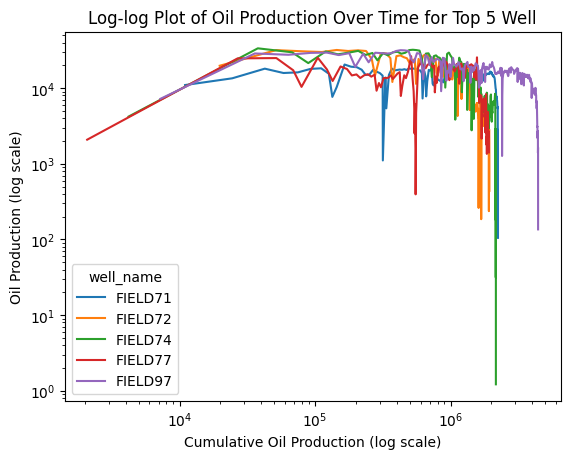

In [42]:
# Plot using seaborn
sns.lineplot(data=df_filtered, x='cumulative_oil_production', y='oil', hue='well_name')

# Set log scale for both x and y axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Cumulative Oil Production (log scale)')
plt.ylabel('Oil Production (log scale)')
plt.title('Log-log Plot of Oil Production Over Time for Top 5 Well')

# Show plot
plt.show()


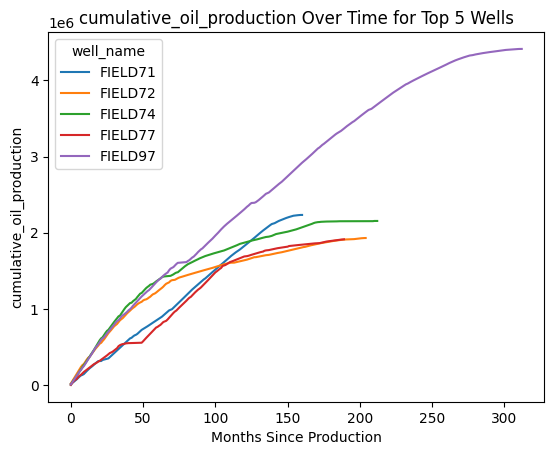

In [43]:
# Plot using seaborn
sns.lineplot(data=df_filtered, x='months_since_first_production', y='cumulative_oil_production', hue='well_name')

# Add labels and title
plt.xlabel('Months Since Production')
plt.ylabel('cumulative_oil_production')
plt.title('cumulative_oil_production Over Time for Top 5 Wells')

# Show plot
plt.show()

In [44]:
# Assuming 'series' is your Series with total oil production over time
total_oil = series['oil'].sum(axis=1)

# Drop zeros from the total_oil Series
total_oil = total_oil[total_oil != 0]

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for total oil production
fig.add_trace(go.Scatter(x=total_oil.index, y=total_oil.values, mode='lines', name='Total Oil Production'))

# Update layout
fig.update_layout(title='Total Oil Production Over Time',
                  xaxis_title='Timestamp',
                  yaxis_title='Total Oil Production')

# Show the plot
fig.show()


In [45]:
# Assuming 'series' is your Series with total oil production over time
series['oil'] = series['oil'].fillna(0)
non_zero_count = series['oil'].apply(lambda x: (x != 0).sum(), axis=1)

# Drop zeros from the total_oil Series
non_zero_count = non_zero_count[non_zero_count != 0]

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for total oil production
fig.add_trace(go.Scatter(x=non_zero_count.index, y=non_zero_count.values, mode='lines', name='Number of producing wells'))

# Update layout
fig.update_layout(title='Number of producing wells',
                  xaxis_title='Timestamp',
                  yaxis_title='Number of producing wells')

# Show the plot
fig.show()


In [46]:
# Assuming 'series' is your Series with total oil production over time
total_gas = series['gas_total'].sum(axis=1)

# Drop zeros from the total_oil Series
total_gas = total_gas[total_gas != 0]

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for total oil production
fig.add_trace(go.Scatter(x=total_gas.index, y=total_gas.values, mode='lines', name='Total Gas Production'))

# Update layout
fig.update_layout(title='Total Gas Production Over Time',
                  xaxis_title='Timestamp',
                  yaxis_title='Total Gas Production')

# Show the plot
fig.show()


In [47]:
# Assuming 'series' is your Series with total oil production over time
GOR = series['gas_total'].sum(axis=1)/(series['oil'].sum(axis=1)  + 1e-6)

# Drop zeros from the total_oil Series
GOR = GOR[GOR != 0]

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for total oil production
fig.add_trace(go.Scatter(x=GOR.index, y=GOR.values, mode='lines', name='GOR'))

# Update layout
fig.update_layout(title='Total GOR  Over Time',
                  xaxis_title='Timestamp',
                  yaxis_title='Total GOR')

# Show the plot
fig.show()


In [48]:
#Decided to build a model for wells, only using their own oil production data 

#Lets create a loop that we can use to predict oil production for each well using various modelling approaches
#In this approach, we are using the last 3 years data only (when available)
#Out of this, 2 year data is used for training and one year data is used for testing

#If 3 year data is not available, we still keep the last years data for testing, and the rest of them are used for training

#Tested models include:

#Linear regression
#Polynomial regression (degree 2)
#Polynomial regression (degree 3)
#Chronos (Amazon Time series model)

# Initialize empty lists for each model
linear_rmse_list = []
poly_rmse_2_list = []
poly_rmse_3_list = []
chronos_rmse_list = []
exponential_rmse_list = []
logarithmic_rmse_list = []

for well in well_list:

    dat = df_[df_.well_name == well]
    X = dat.months_since_first_production.values.reshape(-1, 1)
    y = dat.oil.values.reshape(-1, 1)

    # X contains 'months_since_production' and y contains 'cumulative_oil_production'

    # Define the length of the data
    data_length = len(X)

    # Define the indices for testing
    test_start_index = data_length - 12
    test_end_index = data_length

    # Define the default train_end_index
    train_end_index = data_length - 12
    train_start_index = data_length - 12 - 24
    
    if train_start_index < 0:
        train_start_index = 0 #If we dont have 3 year data, just use what we have for training
        
    # Split the data into training and testing sets
    X_train = X[train_start_index:train_end_index]
    X_test = X[test_start_index:test_end_index]
    y_train = y[train_start_index:train_end_index]
    y_test = y[test_start_index:test_end_index]
        
    # Linear Regression--------------------------------------------------------------------------------
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    linear_pred = linear_reg.predict(X_test)
    linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))

    # Polynomial Regression (Degree 2)--------------------------------------------------------------------------------
    poly_features_2 = PolynomialFeatures(degree=2)
    X_train_poly_2 = poly_features_2.fit_transform(X_train)
    X_test_poly_2 = poly_features_2.transform(X_test)
    poly_reg_2 = LinearRegression()
    poly_reg_2.fit(X_train_poly_2, y_train)
    poly_pred_2 = poly_reg_2.predict(X_test_poly_2)
    poly_rmse_2 = np.sqrt(mean_squared_error(y_test, poly_pred_2))

    # Polynomial Regression (Degree 3)--------------------------------------------------------------------------------
    poly_features_3 = PolynomialFeatures(degree=3)
    X_train_poly_3 = poly_features_3.fit_transform(X_train)
    X_test_poly_3 = poly_features_3.transform(X_test)
    poly_reg_3 = LinearRegression()
    poly_reg_3.fit(X_train_poly_3, y_train)
    poly_pred_3 = poly_reg_3.predict(X_test_poly_3)
    poly_rmse_3 = np.sqrt(mean_squared_error(y_test, poly_pred_3))

    # Exponential Regression--------------------------------------------------------------------------------
    # Log-transform the target variable
    y_train_log = np.log(y_train)

    # Fit the linear regression model
    linear_reg_2 = LinearRegression()
    linear_reg_2.fit(X_train, y_train_log)

    # Predict on test data
    y_test_pred_log = linear_reg_2.predict(X_test)

    # Inverse transform the predictions to get the exponential predictions
    exp_pred = np.exp(y_test_pred_log)
    exponential_rmse = np.sqrt(mean_squared_error(y_test, exp_pred))

    # Logarithmic Regression--------------------------------------------------------------------------------
    try:
        # Log-transform the predictor variable
        X_train_log = np.log(X_train)

        # Fit the linear regression model
        linear_reg_3 = LinearRegression()
        linear_reg_3.fit(X_train_log, y_train)

        # Log-transform the test data and predict
        X_test_log = np.log(X_test)
        log_pred = linear_reg_3.predict(X_test_log)    
        logarithmic_rmse = np.sqrt(mean_squared_error(y_test, log_pred))
    except:
        logarithmic_rmse = 'NaN'

    #Chronos - Amazon--------------------------------------------------------------------------------
    pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-small",
        torch_dtype=torch.bfloat16,
    )

    dat = dat.reset_index(drop=True)
    df = dat
    # context must be either a 1D tensor, a list of 1D tensors,
    # or a left-padded 2D tensor with batch as the first dimension
    context = torch.tensor(df["oil"].iloc[:-12])
    prediction_length = 12
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=24,
        temperature=1.0,
        top_k=50,
        top_p=1.0,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    forecast_index = range(len(df)-prediction_length, len(df))
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    chronos_rmse = np.sqrt(mean_squared_error(y_test, median))

    # Append the RMSE values to their respective lists--------------------------------------------------------------------------------
    linear_rmse_list.append(linear_rmse)
    poly_rmse_2_list.append(poly_rmse_2)
    poly_rmse_3_list.append(poly_rmse_3)
    exponential_rmse_list.append(exponential_rmse)
    logarithmic_rmse_list.append(logarithmic_rmse)
    chronos_rmse_list.append(chronos_rmse)
    

In [49]:
# Create DataFrame using the lists
df_res = pd.DataFrame({
    'well_list': well_list,
    'Linear': linear_rmse_list,
    'Polynomial (Degree 2)': poly_rmse_2_list,
    'Polynomial (Degree 3)': poly_rmse_3_list,
    'Chronos': chronos_rmse_list,
    'Exponential': exponential_rmse_list,
    'Logarithmic': logarithmic_rmse_list
})


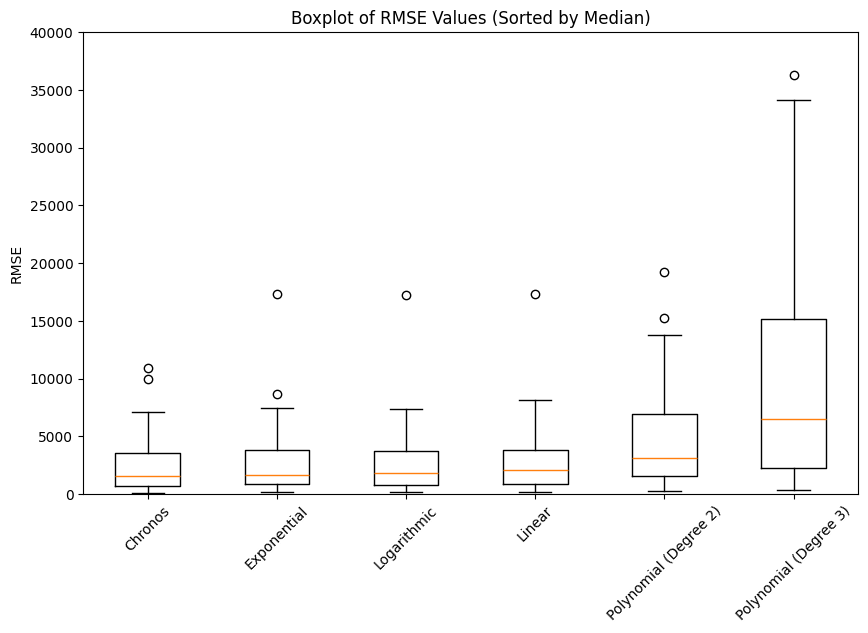

In [50]:
# Drop 'well_name' column from the DataFrame
df_res = df_res[df_res.Logarithmic != 'NaN']
df_numeric = df_res.drop(columns='well_list')

# Calculate the median of each column and sort the DataFrame based on these median values
median_values = df_numeric.median()

sorted_columns = median_values.sort_values().index
df_sorted = df_numeric[sorted_columns]

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df_sorted.values)
plt.title('Boxplot of RMSE Values (Sorted by Median)')
plt.ylabel('RMSE')
plt.xticks(range(1, len(df_sorted.columns) + 1), df_sorted.columns, rotation=45)
plt.ylim(0, 40000)  # Limit y-axis to 1000
plt.show()

In [51]:
median_values.sort_values()

Chronos                  1549.200147
Exponential              1683.679738
Logarithmic              1813.333759
Linear                   2039.630569
Polynomial (Degree 2)    3146.598713
Polynomial (Degree 3)    6460.489846
dtype: object

Chronos model was selected as it provided the best results compared to other approaches (in terms of median RMSE comparisons between Chronos, exponential, logarithmic, linear, second degree polynomial and third degree polynomial approaches)

Visualization

Write a function that takes as an input a well name, and outputs a plot of the well historical oil production values, along with the forecasts from your model (in a different color), where the x-axis is months since start of production. 


In [52]:
def predict_oil_production(well_name):
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv("test.csv",index_col=0)
    
    # Filter the DataFrame for the specific well
    df = df[df['well_name'] == well_name]
    
    # Convert the period column to datetime format
    df['period'] = pd.to_datetime(df['period'])

    # Sort the DataFrame by the 'period' column in ascending order
    df = df.sort_values(by='period')
    
    df = df.reset_index(drop=True)  #Initial index correction due to the wellname filter
    #Filter out zero production
    df = df[df.oil > 0]
    
    #Second index correction to feed the model
    df_ = df.reset_index(drop=True)
    
    # context must be either a 1D tensor, a list of 1D tensors,
    # or a left-padded 2D tensor with batch as the first dimension
    context = torch.tensor(df_["oil"])
    prediction_length = 6
    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=24,
        temperature=1.0,
        top_k=50,
        top_p=1.0,
    ) # forecast shape: [num_series, num_samples, prediction_length]

    # visualize the forecast
    forecast_index = range(len(df)-1, len(df)-1+prediction_length)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    
    plt.figure(figsize=(8, 4))
    plt.plot(df["oil"], color="royalblue", label="historical data")
    plt.plot(forecast_index, median, color="tomato", label="median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    plt.legend()
    plt.grid()
    plt.show()
    

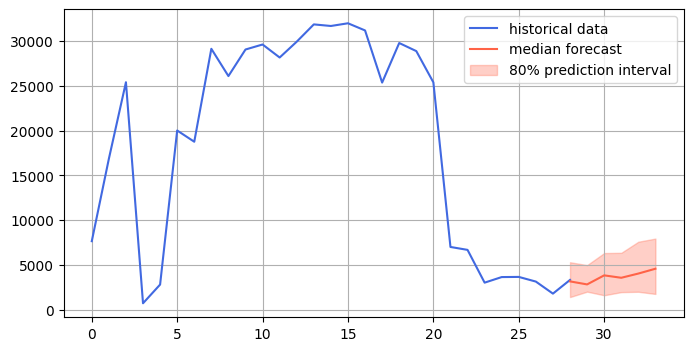

In [53]:
predict_oil_production(well_name='FIELD4')

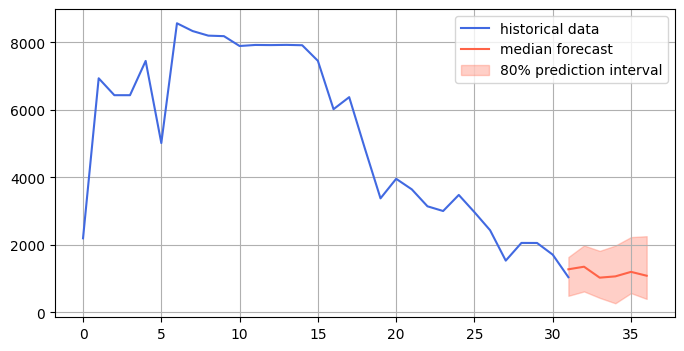

In [54]:
predict_oil_production(well_name='FIELD55D')

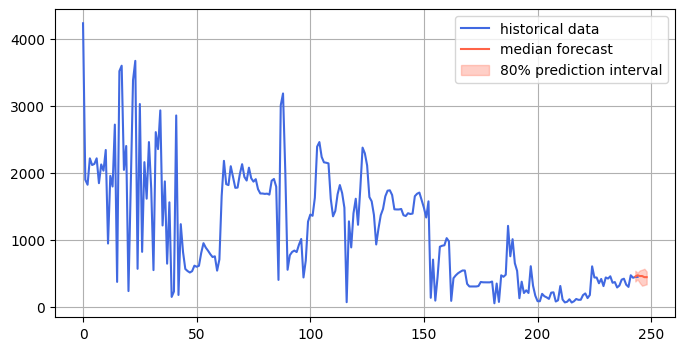

In [55]:
predict_oil_production(well_name='FIELD216')

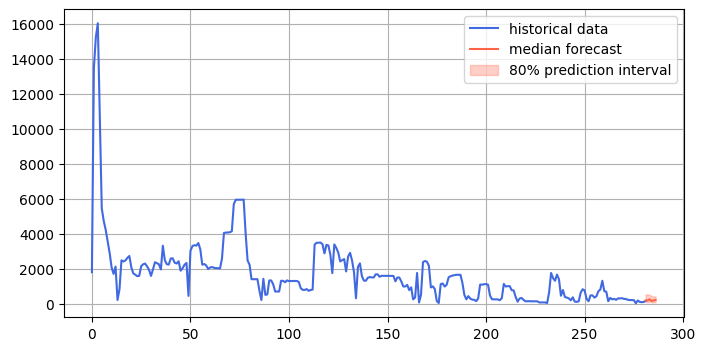

In [56]:
predict_oil_production(well_name='FIELD211')